<H1>2016 MLB Pitching Injuries and Prior Pitcher Activity</H1> 

<i>an analysis by Michael Klear</i>

I'm investigating a correlation between pitcher appearing on the disabled list (DL) in 2016 and their activity in previous seasons. To quantify pitcher activity, I use out volume, or inning volume times three.

<H3>The three questions I'd like to answer are:</H3>


1. Is there a correlation between pitcher out volume in 2015 and DL appearances in 2016?
2. Is there a similar correlation for pitchers who appeared on the 2016 DL for Tommy John surgery?
3. Is there a correlation between Tommy John surgeries in 2016 and pitcher out volume in 2014 (two seasons prior)?

In [101]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from datawrangler import format_names, reconcile_names, build_frame
import matplotlib.pyplot as plt
%matplotlib inline

<H3>Code</H3>

The functions I wrote to help wrangle this data into a usable format (datawrangler.py) can be found at https://github.com/AlliedToasters/pitchers/blob/master/datawrangler.py.

<H3>Sources</H3>

I found a comprehensive list of pitcher information as a part of the exhaustive Lahman's Baseball Database set (http://www.seanlahman.com/baseball-archive/statistics/). It includes player stats dating back to 1871, which is really cool!

I collected the disabled list information for the 2016 season from baseballheatmaps.com (http://www.baseballheatmaps.com/disabled-list-data/).

<H2>Question 1: 2015 Activity vs. 2016 Disabled List</H2>

In [102]:
pitching_data = pd.read_csv('Pitching.csv')

I extract the following information for each pitcher who appeared in 2015 from the Lahman database:

* (<b>PSOV</b>) Previous Season Out Volume: Total number of outs pitched prior to 2015 season
* (<b>NoPS</b>) Number of Previous Seasons: Total number of seasons this pitcher appeared prior 2015
* (<b>OV/S</b>) Out Volume per Season: The average outs pitched per season prior to 2015
* (<b>OV2015</b>) 2015 Out Volume: The number of outs pitched in 2015
* (<b>NOV2015</b>) Normalized 2015 Out Volume: The ratio of OV2015 to OV/S
* (<b>Inj2016</b>) Injured in 2016: Denotes whether the pitcher appeared on disabled list in 2016.

In [103]:
df = build_frame(pitching_data)

Our dataframe looks like this:

In [104]:
df.head()

,PSOV,NoPS,OV/S,OV2015,NOV2015,Inj2016
rossro01,617,3,205.667,182,0.884927,False
webstal01,268,2,134,93,0.69403,False
perezol01,3759,12,313.25,123,0.392658,False
severlu01,0,0,NaN,187,1,False
montafr01,0,0,NaN,45,1,False


Now we'll integrate the disabled list data, which looks like this:

In [105]:
inj2016 = pd.read_csv('2016_disabled_list.csv')
inj2016.head()

,Name,Season,Team,Position,on_DL,off_dl,days,Location,Injury Type,Side/Location,Location id,PlayerId,Teamid
0,A.J. Griffin,2016,Rangers,RHP,05/08/16,10/03/16,148,shoulder,stiffness,right,18,11132,13
1,A.J. Morris,2016,Reds,RHP,06/16/16,10/03/16,109,shoulder,strained,right,18,9919,18
2,A.J. Pierzynski,2016,Braves,C,08/17/16,09/01/16,15,hamstring,strained,left,5,746,16
3,A.J. Pierzynski,2016,Braves,C,09/11/16,10/03/16,22,hamstring,strained,NaN,5,746,16
4,A.J. Pollock,2016,Diamondbacks,CF,04/03/16,08/26/16,145,elbow,fractured,right,8,9256,15


This spreadsheet contains all players on the disabled list. I'll select the pitchers, generate a list of names, format the names on this list, match them to names in our dataframe, and mark these players as injured in 2016 (Inj2016 = True). One player, Rubby de la Rosa, has a unique format that I address explicitly.

In [106]:
inj2016_names = list(inj2016[inj2016['Position'] == 'RHP'].Name) + list(inj2016[inj2016['Position'] == 'LHP'].Name)
inj2016_names = list(set(inj2016_names)) #remove duplicates, when player appears more than once on DL

In [107]:
print('The names on the list came in this format: {}'.format(inj2016_names[0]))
inj2016_names = format_names(inj2016_names)
inj2016_names.remove('rosaru01')
inj2016_names.append('delarru01')
print('The names on the list now appear in this format: {}'.format(inj2016_names[0]))

The names on the list came in this format: Andrew Cashner
The names on the list now appear in this format: cashnan01


In [108]:
inj2016_names, missing_players = reconcile_names(inj2016_names, df.index)
for player in missing_players:
    inj2016_names.remove(player)

print('{} names were removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(inj2016_names)))

45 names were not found.
45 names were removed from the list.
The injured group contains 231 players.


The players removed from the list did not appear in 2015.

In [109]:
for name in inj2016_names:
    df.set_value(name, 'Inj2016', True)

<H3>2015 Out Volume vs. 2016 Disabled List</H3>

The first group, pitchers who appeared in 2015 and were not on the 2016 disable list, are blue in the following plot. Those on the disabled list in 2016 are red. The black dotted line represents the population mean out volume for 2015, the red dotted line is the mean 2015 out volume for the disabled list group, and the blue dotted line is the mean 2015 out volume for the uninjured group.

The number of players, the y-axis on the following plot, is normalized so that the two distributions can be compared "apples to apples."

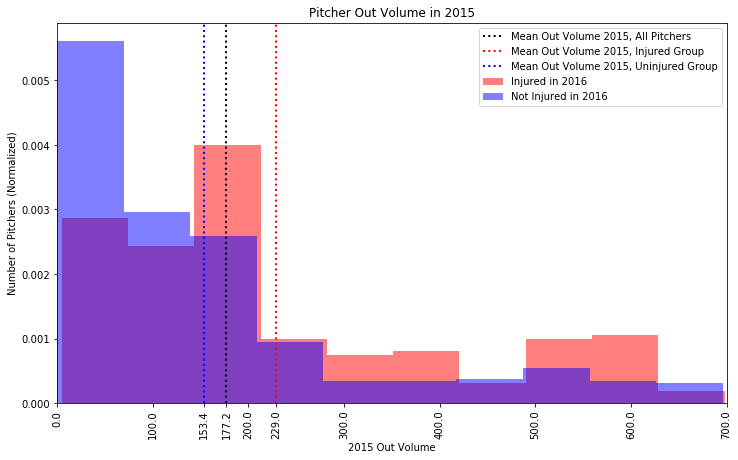

In [110]:
pop_mean = df.OV2015.mean()
inj_mean = df[df['Inj2016'] == True].OV2015.mean()
uninj_mean = df[df['Inj2016'] == False].OV2015.mean()

plt.figure(figsize=(12, 7));
plt.axvline(pop_mean, color='black', linestyle='dotted', linewidth=2, label='Mean Out Volume 2015, All Pitchers')
plt.hist(df[df['Inj2016']==True].OV2015, color='r', alpha=.5, normed=True, label='Injured in 2016');
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean Out Volume 2015, Injured Group');
plt.hist(df[df['Inj2016']==False].OV2015, color='b', alpha=.5, normed=True, label='Not Injured in 2016');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean Out Volume 2015, Uninjured Group');
plt.xticks((list(plt.xticks()[0])+[pop_mean, inj_mean, uninj_mean]), rotation=90);
plt.title('Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Out Volume');
ax = plt.subplot(111);
ax.set_xlim(0, 700);
plt.legend();

In [111]:
print(ttest_ind(df[df['Inj2016']==True]['OV2015'], df[df['Inj2016']==False]['OV2015'], equal_var = False))

Ttest_indResult(statistic=5.3496276345264411, pvalue=1.4630842233344046e-07)


We can see that the mean 2015 out volume for the injured group is greater than that of all pitchers in 2015 and the uninjured group.

Our t-test confirms a statistically significant positive correlation (t-statistic greater than 5) between 2015 out volume and the 2016 disabled list with a p-value of .00000015, far below the .05 threshold for significance.

<H3>Normalized 2015 Out Volume vs. 2016 Disabled List</H3>

Now I compare the 2016 DL to the normalized 2015 out volume (NOV2015). Remember that the NOV2015 is the ratio of 2015 out volume to each player's average out volume per season based on seasons prior to 2015. If 2015 is the pitcher's MLB debut, NOV2015 is equal to one.

To look at NOV2015, it's important to note that there are a few very high NOV2015 values. I'm going to set any value higher than five equal to five, in the group "5 or more." Think of this group as "pitching five or more times their average number of outs per season in 2015."

As with the previous figure, remember that the quantity of players on the y-axis is normalized so the distributions are comparable.

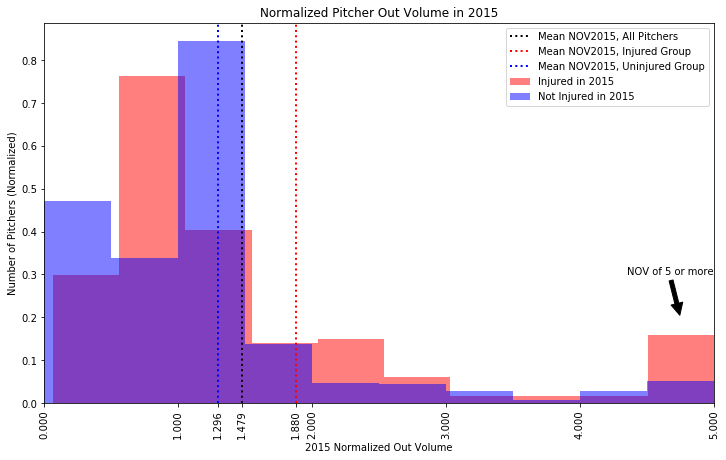

In [112]:
pop_mean = df.NOV2015.mean()
inj_mean = df[df['Inj2016'] == True].NOV2015.mean()
uninj_mean = df[df['Inj2016'] == False].NOV2015.mean()

nov2015_inj = list(df[df['Inj2016']==True].NOV2015)
for i, val in enumerate(nov2015_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_inj[i] = 5
        
nov2015_uninj = list(df[df['Inj2016']==False].NOV2015)
for i, val in enumerate(nov2015_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_uninj[i] = 5
        
fig = plt.figure(figsize=(12, 7));  
ax = fig.add_subplot(111)
plt.axvline(pop_mean, color='black', linestyle='dotted', linewidth=2, label='Mean NOV2015, All Pitchers');
plt.hist(nov2015_inj, color='r', alpha=.5, normed=True, label='Injured in 2015');
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean NOV2015, Injured Group');
plt.hist(nov2015_uninj, color='b', alpha=.5, normed=True, label='Not Injured in 2015');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean NOV2015, Uninjured Group')
plt.xticks((list(plt.xticks()[0])+[pop_mean, inj_mean, uninj_mean]), rotation=90);
plt.title('Normalized Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Normalized Out Volume');
ax.annotate('NOV of 5 or more', xy=(4.75, .2), xytext=(4.35, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            );
ax.set_xlim(0, 5)
plt.legend();

In [113]:
print(ttest_ind(df[df['Inj2016']==True]['NOV2015'], df[df['Inj2016']==False]['NOV2015'], equal_var = False))

Ttest_indResult(statistic=2.4133352609589909, pvalue=0.016315466493127539)


We see that the mean NOV2015 for the injured group is higher than that of the uninjured group and that of all pitchers appearing in 2015. Notice that, of the pitchers with very high NOV2015, a large majority ended up appearing on the 2016 disabled list.

Our t-test verifies a statistically significant positive correlation (t-statistic greater than 2) with a p-value of 0.016, below the .05 threshold for significance.

<H2>Question 2: 2015 Activity vs. 2016 Disability due to Tommy John Surgery</H2>

Our injured group this time includes those players who appeared on the disabled list in 2016 with "Tommy John surgery" as the reason for disability, and uninjured will be all other players who appeared in 2015.

In [114]:
df.Inj2016 = False

In [115]:
tj2016 = inj2016[inj2016['Injury Type'] == 'Tommy John surgery']

In [116]:
tj_names = list(tj2016.Name)
tj_names = list(set(tj_names)) #Remove any duplicates
tj_names = format_names(tj_names)
tj_names, missing_players = reconcile_names(tj_names, df.index)
for player in missing_players:
    tj_names.remove(player)
print('{} names have been removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(tj_names)))

11 names were not found.
11 names have been removed from the list.
The injured group contains 11 players.


We can see that this is a much smaller group of 22 players, only 11 of whom appeared in 2015.

In [117]:
df.Inj2016 = False
for name in tj_names:
    df.set_value(name, 'Inj2016', True)

<H3>2015 Out Volume vs. 2016 Tommy John Disability</H3>


Since the injured group is so tiny, the set of all pitchers is almost identical to the "uninjured" group. The mean out volume for the uninjured groups and the set of all pitchers in 2015 are also very close to identical. For that reason, I only plot the uninjured mean out volume.

As before, we'll normalize these distributions so we can compare them qualitatively.

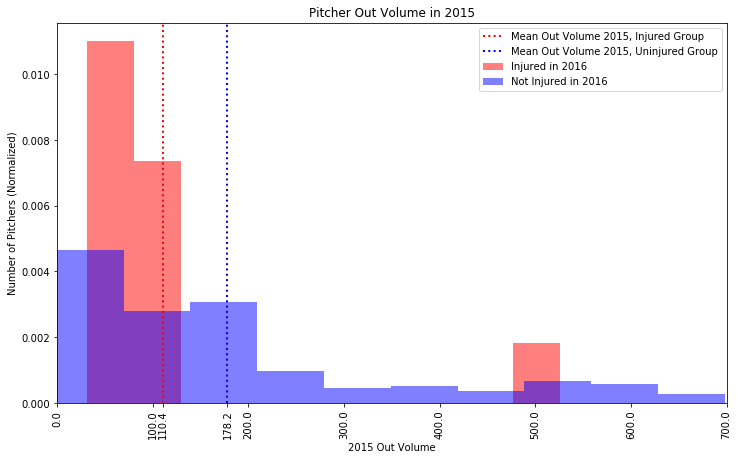

In [118]:
inj_mean = df[df['Inj2016'] == True].OV2015.mean()
uninj_mean = df[df['Inj2016'] == False].OV2015.mean()

plt.figure(figsize=(12, 7))
plt.hist(df[df['Inj2016']==True].OV2015, color='r', alpha=.5, normed=True, label='Injured in 2016');
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean Out Volume 2015, Injured Group');
plt.hist(df[df['Inj2016']==False].OV2015, color='b', alpha=.5, normed=True, label='Not Injured in 2016');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean Out Volume 2015, Uninjured Group');
plt.xticks((list(plt.xticks()[0])+[inj_mean, uninj_mean]), rotation=90);
plt.title('Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Out Volume');
ax = plt.subplot(111)
ax.set_xlim(0, 700);
plt.legend();

In [119]:
print(ttest_ind(df[df['Inj2016']==True]['OV2015'], df[df['Inj2016']==False]['OV2015'], equal_var = False))

Ttest_indResult(statistic=-1.5837520187534455, pvalue=0.14295507256700887)


It may not be surprising that the out volume of the Tommy John group in 2015 is actually lower than that of the uninjured group. This is because these pitchers usually go through other injuries and less-invasive rehabilitation programs before committing to the surgery. This will generally cause pitchers to miss games.

The t-test reports a negative correlation, with a t-statistic less than  -1, but with the high p-value of .14, it's not considered statistically significant. This inconclusive result is probably, in part, due to the small sample size.

<H3>Normalized 2015 Out Volume vs. 2016 Tommy John Disability</H3>

We'll summarize this information in the same way as in the previous question, grouping all NOV2015 greater than five in the same group of "five or more."

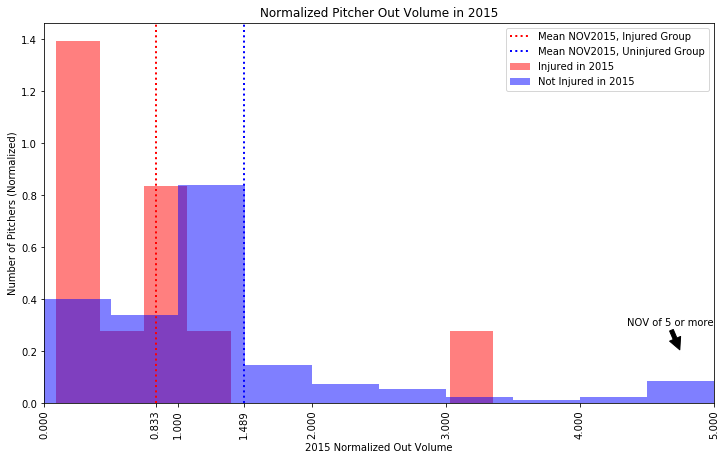

In [120]:
inj_mean = df[df['Inj2016'] == True].NOV2015.mean()
uninj_mean = df[df['Inj2016'] == False].NOV2015.mean()

nov2015_inj = list(df[df['Inj2016']==True].NOV2015)
for i, val in enumerate(nov2015_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_inj[i] = 5
        
nov2015_uninj = list(df[df['Inj2016']==False].NOV2015)
for i, val in enumerate(nov2015_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_uninj[i] = 5
        
fig = plt.figure(figsize=(12, 7));  
ax = fig.add_subplot(111)
plt.hist(nov2015_inj, color='r', alpha=.5, normed=True, label='Injured in 2015');
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean NOV2015, Injured Group');
plt.hist(nov2015_uninj, color='b', alpha=.5, normed=True, label='Not Injured in 2015');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean NOV2015, Uninjured Group')
plt.xticks((list(plt.xticks()[0])+[inj_mean, uninj_mean]), rotation=90);
plt.title('Normalized Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Normalized Out Volume');
ax.annotate('NOV of 5 or more', xy=(4.75, .2), xytext=(4.35, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            );
ax.set_xlim(0, 5)
plt.legend();

In [121]:
print(ttest_ind(df[df['Inj2016']==True]['NOV2015'], df[df['Inj2016']==False]['NOV2015'], equal_var = False))

Ttest_indResult(statistic=-2.2153370671432464, pvalue=0.045292088130213487)


Notice that none of the pitchers who were disabled due to Tommy John surgery in 2016 pitched more than four times their average season's worth of outs in 2015. Many of the injured group have an NOV2015 less than one, meaning they pitched less outs than an average season in 2015.

This t-test reports a statistically significant negative correlation between NOV2015 and disability due to Tommy John surgery in 2016, with a t-statistic less than negative 2 and a p-value of .045, just beneath the threshold for significance. 

This seems to agree with intuition. Because of complications prior to Tommy John surgery, pitchers appear to pitch less innings than usual in the season before surgery.

Let's go back another season and look at this same group of injured pitchers and their out volume in 2014.

<H2>Question 3: 2014 Activity vs. 2016 Disability due to Tommy John Surgery</H2>

We'll build the same data structure, this time with 2014 numbers rather than 2015.

In [122]:
df14 = build_frame(pitching_data, 2014)

Our dataframe looks like this:

In [123]:
df14.head()

,PSOV,NoPS,OV/S,OV2014,NOV2014,Inj2016
elbersc01,277,5,55.4,13,0.234657,False
cumptbr01,92,1,92,210,2.28261,False
perezch01,999,6,166.5,139,0.834835,False
rossro01,382,2,191,235,1.23037,False
webstal01,91,1,91,177,1.94505,False


I generate, format, and match our list of injured players and tag them as injured in our dataframe.

In [124]:
tj2016 = inj2016[inj2016['Injury Type'] == 'Tommy John surgery']
tj_names = list(tj2016.Name)
tj_names = list(set(tj_names)) #Remove any duplicates
tj_names = format_names(tj_names)
tj_names, missing_players = reconcile_names(tj_names, df14.index)
len(tj_names)
for player in missing_players:
    tj_names.remove(player)
print('{} names have been removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(tj_names)))

5 names were not found.
5 names have been removed from the list.
The injured group contains 17 players.


Notice that, of the 22 players listed as disabled for Tommy John surgery in 2016, 17 appeared in 2014. Only 11 appeared in 2015.

In [125]:
for name in tj_names:
    df14.set_value(name, 'Inj2016', True)

<H3>2014 Out Volume vs. 2016 Tommy John Disability</H3>

Let's look at the distributions. As with the previous study, the sample size is so small that the uninjured group and the set of all pitchers in 2014 are close to identical, so we can treat their mean values as essentially the same.

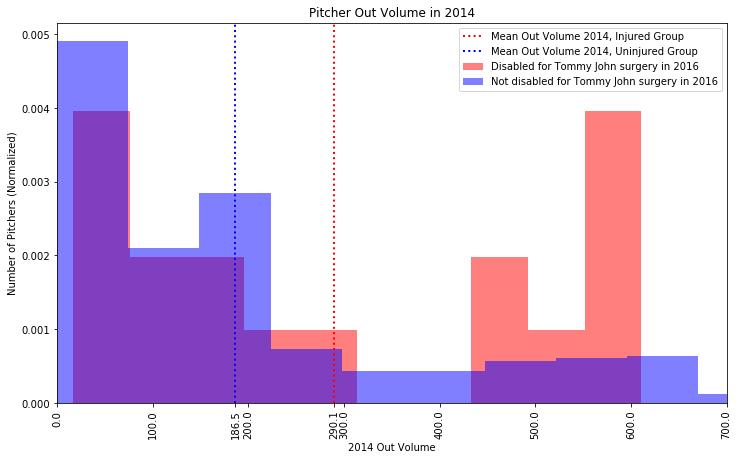

In [126]:
inj_mean = df14[df14['Inj2016'] == True].OV2014.mean()
uninj_mean = df14[df14['Inj2016'] == False].OV2014.mean()

plt.figure(figsize=(12, 7));
plt.hist(df14[df14['Inj2016']==True].OV2014, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016');
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean Out Volume 2014, Injured Group');
plt.hist(df14[df14['Inj2016']==False].OV2014, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean Out Volume 2014, Uninjured Group');
plt.xticks((list(plt.xticks()[0])+[inj_mean, uninj_mean]), rotation=90);
plt.title('Pitcher Out Volume in 2014');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2014 Out Volume');
ax = plt.subplot(111);
ax.set_xlim(0, 700);
plt.legend();

In [127]:
print(ttest_ind(df14[df14['Inj2016']==True]['OV2014'], df14[df14['Inj2016']==False]['OV2014'], equal_var = False))

Ttest_indResult(statistic=1.942437900982964, pvalue=0.069256894578068537)


Notice the high concentration of our Tommy John group pitching a high number of outs (between 450 and 600) in 2014. The mean number of outs pitched in 2014 for the injured group is much higher than that of the uninjured group and of the set of all pitchers appearing in 2014.

However, the t-test is still inconclusive, with a p-value of .069, above the threshold for statistical significance. While there is a big difference in the mean 2014 out volume for the two groups, the high p-value does not allow us to reject the null hypothesis: that there is no correlation between pitcher activity in 2014 and disability due to Tommy John surgery in 2016.

<H3>Normalized 2014 Out Volume vs. 2016 Tommy John Disability</H3>

I present this information as before, with all NOV2014 greater than five in the same group.

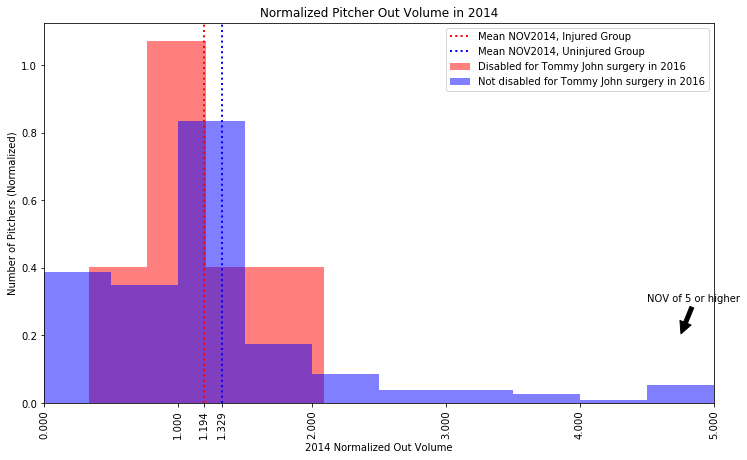

In [128]:
inj_mean = df14[df14['Inj2016'] == True].NOV2014.mean()
uninj_mean = df14[df14['Inj2016'] == False].NOV2014.mean()

nov2014_inj = list(df14[df14['Inj2016']==True].NOV2014)
for i, val in enumerate(nov2014_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2014_inj[i] = 5
        
nov2014_uninj = list(df14[df14['Inj2016']==False].NOV2014)
for i, val in enumerate(nov2014_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2014_uninj[i] = 5
        
fig = plt.figure(figsize=(12, 7));  
ax = fig.add_subplot(111)
plt.hist(nov2014_inj, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016', bins=4);
plt.axvline(inj_mean, color='r', linestyle='dotted', linewidth=2, label='Mean NOV2014, Injured Group');
plt.hist(nov2014_uninj, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.axvline(uninj_mean, color='b', linestyle='dotted', linewidth=2, label='Mean NOV2014, Uninjured Group');
plt.xticks((list(plt.xticks()[0])+[inj_mean, uninj_mean]), rotation=90);
plt.title('Normalized Pitcher Out Volume in 2014');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2014 Normalized Out Volume');
ax.annotate('NOV of 5 or higher', xy=(4.75, .2), xytext=(4.5, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.set_xlim(0, 5);
plt.legend();

In [129]:
print(ttest_ind(df14[df14['Inj2016']==True]['NOV2014'], df14[df14['Inj2016']==False]['NOV2014'], equal_var = False))

Ttest_indResult(statistic=-0.96816337049765877, pvalue=0.34094583334138967)


The mean NOV2014 for our injured group is smaller than the mean NOV2014 of the uninjured group.

Our t-test here is inconclusive, with a p-value of .34. We cannot reject the null hypothesis, that there is no correlation between NOV2014 and Tommy John disability in 2016.

The inconclusive results here are likely due to small sample size. It is interesting to note the high concentration of Tommy John disabilities in 2016 that pitched between 450 and 600 outs in 2014.

<H2>Conclusion</H2>

While we asked some interesting questions in this study, the most important and statistically significant correlation I found was between pitcher out volume (both nominal and normalized) in 2015 and pitcher disability (for any reason) in 2016.

To reduce the chance of appearing on the disabled list in the following season, coaches should try to keep the number of outs that each pitcher delivers in a given season limited. These limits appear to be:

* A maximum of 177 total outs in a season, preferably 153 or less.
* No more than 1.5 times that player's average seasonal outs pitched, preferably 1.3 or less.

For busier starting pitchers who are used to a high out volume in a season, the latter limit may be more realistic to adhere to. For rookie pitchers with limited prior major league pitching experience, the former limit is probably the best guideline.

We were not able to conclusively find any correlation between pitching activity and Tommy John surgery, but our results do not rule them out. Further research is needed to find or rule out these correlations.